# Role Moderation of SDT → Intervention-Specific Acceptance (China Sample)

Goal of H3

Test whether the association between self-determination (SDT; TENS_Life_mean_imputed) and intervention-specific acceptance:

- Accept_avatar_imputed (AI avatar / generic AI therapist)
- Accept_chatbot_imputed (AI chatbot)
- Accept_tele_imputed (teletherapy / human therapist)

is moderated by clinical role (role_label: client vs therapist) in the Chinese sample.

Note: Because the USA sample has role_label = "unknown" for all cases, a joint SDT × Country × Role model is not identified. Cross-country differences are instead handled via Country main effects in H1/H2. H3 focuses on role moderation within China where both clients and therapists are observed.

# 0.0 Paths and Data Loading

In [12]:
from __future__ import annotations

import warnings
from pathlib import Path
from typing import Dict, List

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings("ignore", category=FutureWarning)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["font.size"] = 11

PROJECT_ROOT = Path.cwd().resolve()
DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = DATA_DIR / "output"
PROCESSED_PATH = OUTPUT_DIR / "processed.csv"

processed = pd.read_csv(PROCESSED_PATH)

# 1.0. Define H3 Contextual Sample (China Only) and Descriptives

Pulled everything from processed.csv using the imputed variables:

- Outcomes: Accept_avatar_imputed, Accept_chatbot_imputed, Accept_tele_imputed
- Predictor: TENS_Life_mean_imputed
- Covariates: age_imputed, gender, PHQ5_mean_imputed, SSRPH_mean_imputed, GAAIS_mean_imputed ET_mean_imputed, plus Country and role_label.

Restricted to:
- Country == "China"
- role_label ∈ {"client", "therapist"}
- non-missing gender + role

Final N = 485 (therapists = 269, clients = 216).

In [13]:
h3_vars = [
    # outcomes
    "Accept_avatar_imputed",
    "Accept_chatbot_imputed",
    "Accept_tele_imputed",
    # SDT predictor
    "TENS_Life_mean_imputed",
    # covariates
    "age_imputed", "gender", "Country", "role_label",
    "PHQ5_mean_imputed", "SSRPH_mean_imputed",
    "GAAIS_mean_imputed", "ET_mean_imputed",
]

context_df = processed[h3_vars].copy()

## 1.1. Focus on the Chinese sample where role_label is known (client vs therapist)

In [15]:
context_df = context_df[
    (context_df["Country"] == "China") &
    (context_df["role_label"].isin(["client", "therapist"]))
].copy()

# Drop rows missing key covariates (gender, role)
context_df = context_df.dropna(subset=["gender", "role_label"])

In [16]:
print("H3 contextual sample (China, client/therapist only):")
print("N =", len(context_df))

H3 contextual sample (China, client/therapist only):
N = 485


In [17]:
print("Role distribution:")
print(context_df["role_label"].value_counts(dropna=False))

Role distribution:
role_label
therapist    269
client       216
Name: count, dtype: int64


In [18]:
print("Gender distribution:")
print(context_df["gender"].value_counts(dropna=False))

Gender distribution:
gender
2.0    251
1.0    228
3.0      6
Name: count, dtype: int64


In [19]:
print("Descriptives for SDT and outcomes (China only):")
display(
    context_df[
        ["TENS_Life_mean_imputed",
         "Accept_avatar_imputed",
         "Accept_chatbot_imputed",
         "Accept_tele_imputed"]
    ].describe().T
)

Descriptives for SDT and outcomes (China only):


,count,mean,std,min,25%,50%,75%,max
TENS_Life_mean_imputed,485.0,4.351203,0.992311,1.000000,3.777778,4.333333,5.000000,7.0
Accept_avatar_imputed,485.0,3.673957,0.560475,1.166667,3.333333,3.630952,3.964286,5.0
Accept_chatbot_imputed,485.0,3.692391,0.561215,1.071429,3.357143,3.666667,4.000000,5.0
Accept_tele_imputed,485.0,3.684413,0.544324,1.000000,3.357143,3.630952,3.952381,5.0


# 2.0. Center SDT and Age

In this China subsample, age_imputed has mean ≈ 12.36. That’s unusual if “age” is meant in years, but this is a data / measurement issue, not a modeling bug.

In [20]:
# Center key continuous predictors for interpretability
for col in ["TENS_Life_mean_imputed", "age_imputed"]:
    mean_val = context_df[col].mean()
    context_df[f"{col}_c"] = context_df[col] - mean_val
    print(f"{col} mean for centering (China H3 sample): {mean_val:.3f}")

TENS_Life_mean_imputed mean for centering (China H3 sample): 4.351
age_imputed mean for centering (China H3 sample): 12.359


In [21]:
print("Means of centered variables (≈ 0):")
print(context_df[["TENS_Life_mean_imputed_c", "age_imputed_c"]].mean())

Means of centered variables (≈ 0):
TENS_Life_mean_imputed_c    3.332958e-16
age_imputed_c              -1.758044e-16
dtype: float64


# 3.0. Helper Function: Baseline vs Role-Moderation Models for Each Outcome

Baseline models: {outcome} ~ TENS_Life_mean_imputed_c + age_imputed_c + C(gender) + PHQ5_mean_imputed + SSRPH_mean_imputed + GAAIS_mean_imputed + ET_mean_imputed + C(role_label)

Role-moderation models: {outcome} ~ TENS_Life_mean_imputed_c * C(role_label) + age_imputed_c + C(gender) + PHQ5_mean_imputed + SSRPH_mean_imputed + GAAIS_mean_imputed + ET_mean_imputed

In [22]:
def fit_role_moderation(outcome: str, data: pd.DataFrame):

    cols = [
        outcome,
        "TENS_Life_mean_imputed_c",
        "age_imputed_c",
        "gender", "role_label",
        "PHQ5_mean_imputed",
        "SSRPH_mean_imputed",
        "GAAIS_mean_imputed",
        "ET_mean_imputed",
    ]

    sub_df = data[cols].dropna().copy()
    if sub_df.empty:
        print(f"\n{outcome}: no complete cases available for role moderation.")
        return None, None, None

    print(f"\n=== H3 Role moderation for {outcome} (China; N={len(sub_df)}) ===")

    # Baseline model: SDT main effect + covariates + role main effect
    baseline_formula = (
        f"{outcome} ~ "
        "TENS_Life_mean_imputed_c "
        "+ age_imputed_c + C(gender) "
        "+ PHQ5_mean_imputed + SSRPH_mean_imputed "
        "+ GAAIS_mean_imputed + ET_mean_imputed "
        "+ C(role_label)"
    )

    baseline_model = smf.ols(formula=baseline_formula, data=sub_df).fit()
    print("\nBaseline model (main effects only):")
    display(baseline_model.summary().tables[1])
    print(f"R² (baseline) = {baseline_model.rsquared:.3f}")

    # Role-moderation model: add SDT × role interaction
    role_formula = (
        f"{outcome} ~ "
        "TENS_Life_mean_imputed_c * C(role_label) "
        "+ age_imputed_c + C(gender) "
        "+ PHQ5_mean_imputed + SSRPH_mean_imputed "
        "+ GAAIS_mean_imputed + ET_mean_imputed"
    )

    role_model = smf.ols(formula=role_formula, data=sub_df).fit()
    print("\nRole-moderation model (TENS × role_label):")
    display(role_model.summary().tables[1])
    print(f"R² (role-moderation) = {role_model.rsquared:.3f}")

    # Model comparison via ANOVA
    print("\nModel comparison (Baseline vs Role-moderation):")
    comp = anova_lm(baseline_model, role_model)
    display(comp)

    return sub_df, baseline_model, role_model

In [23]:
h3_outcomes = [
    "Accept_avatar_imputed",
    "Accept_chatbot_imputed",
    "Accept_tele_imputed",
]

h3_models: Dict[str, Dict[str, object]] = {}

for outcome in h3_outcomes:
    sub_df, base_m, role_m = fit_role_moderation(outcome, context_df)
    h3_models[outcome] = {
        "data": sub_df,
        "baseline": base_m,
        "role_model": role_m,
    }


=== H3 Role moderation for Accept_avatar_imputed (China; N=485) ===

Baseline model (main effects only):


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.3400,0.210,11.123,0.000,1.927,2.753
C(gender)[T.2.0],-0.0411,0.042,-0.975,0.330,-0.124,0.042
C(gender)[T.3.0],-0.5113,0.189,-2.701,0.007,-0.883,-0.139
C(role_label)[T.therapist],0.0346,0.042,0.828,0.408,-0.048,0.117
TENS_Life_mean_imputed_c,0.2078,0.027,7.663,0.000,0.155,0.261
age_imputed_c,-0.0016,0.003,-0.600,0.549,-0.007,0.004
PHQ5_mean_imputed,-0.0420,0.025,-1.675,0.095,-0.091,0.007
SSRPH_mean_imputed,0.0859,0.028,3.109,0.002,0.032,0.140
GAAIS_mean_imputed,0.1106,0.033,3.335,0.001,0.045,0.176
ET_mean_imputed,0.1499,0.028,5.317,0.000,0.094,0.205


R² (baseline) = 0.365

Role-moderation model (TENS × role_label):


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.3408,0.211,11.113,0.000,1.927,2.755
C(role_label)[T.therapist],0.0343,0.042,0.820,0.413,-0.048,0.117
C(gender)[T.2.0],-0.0418,0.042,-0.987,0.324,-0.125,0.041
C(gender)[T.3.0],-0.5085,0.190,-2.676,0.008,-0.882,-0.135
TENS_Life_mean_imputed_c,0.2123,0.036,5.946,0.000,0.142,0.282
TENS_Life_mean_imputed_c:C(role_label)[T.therapist],-0.0084,0.043,-0.196,0.845,-0.093,0.076
age_imputed_c,-0.0016,0.003,-0.604,0.546,-0.007,0.004
PHQ5_mean_imputed,-0.0422,0.025,-1.681,0.093,-0.092,0.007
SSRPH_mean_imputed,0.0859,0.028,3.106,0.002,0.032,0.140
GAAIS_mean_imputed,0.1100,0.033,3.302,0.001,0.045,0.175


R² (role-moderation) = 0.365

Model comparison (Baseline vs Role-moderation):


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,475.0,96.616198,0.0,NaN,NaN,NaN
1,474.0,96.608387,1.0,0.007811,0.038324,0.844878



=== H3 Role moderation for Accept_chatbot_imputed (China; N=485) ===

Baseline model (main effects only):


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.2190,0.216,10.291,0.000,1.795,2.643
C(gender)[T.2.0],-0.0077,0.043,-0.178,0.859,-0.093,0.077
C(gender)[T.3.0],-0.3762,0.194,-1.940,0.053,-0.757,0.005
C(role_label)[T.therapist],-0.0050,0.043,-0.117,0.907,-0.089,0.079
TENS_Life_mean_imputed_c,0.1749,0.028,6.295,0.000,0.120,0.230
age_imputed_c,-0.0025,0.003,-0.900,0.369,-0.008,0.003
PHQ5_mean_imputed,-0.0228,0.026,-0.889,0.374,-0.073,0.028
SSRPH_mean_imputed,0.0709,0.028,2.504,0.013,0.015,0.127
GAAIS_mean_imputed,0.1096,0.034,3.225,0.001,0.043,0.176
ET_mean_imputed,0.1823,0.029,6.309,0.000,0.126,0.239


R² (baseline) = 0.334

Role-moderation model (TENS × role_label):


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.2205,0.216,10.287,0.000,1.796,2.645
C(role_label)[T.therapist],-0.0056,0.043,-0.129,0.897,-0.090,0.079
C(gender)[T.2.0],-0.0090,0.043,-0.207,0.836,-0.094,0.076
C(gender)[T.3.0],-0.3710,0.195,-1.905,0.057,-0.754,0.012
TENS_Life_mean_imputed_c,0.1835,0.037,5.015,0.000,0.112,0.255
TENS_Life_mean_imputed_c:C(role_label)[T.therapist],-0.0159,0.044,-0.361,0.718,-0.103,0.071
age_imputed_c,-0.0025,0.003,-0.909,0.364,-0.008,0.003
PHQ5_mean_imputed,-0.0233,0.026,-0.906,0.366,-0.074,0.027
SSRPH_mean_imputed,0.0709,0.028,2.502,0.013,0.015,0.127
GAAIS_mean_imputed,0.1085,0.034,3.179,0.002,0.041,0.176


R² (role-moderation) = 0.334

Model comparison (Baseline vs Role-moderation):


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,475.0,101.489888,0.0,NaN,NaN,NaN
1,474.0,101.461924,1.0,0.027964,0.13064,0.717931



=== H3 Role moderation for Accept_tele_imputed (China; N=485) ===

Baseline model (main effects only):


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.3152,0.204,11.375,0.000,1.915,2.715
C(gender)[T.2.0],-0.0453,0.041,-1.109,0.268,-0.125,0.035
C(gender)[T.3.0],-0.5710,0.183,-3.118,0.002,-0.931,-0.211
C(role_label)[T.therapist],0.0022,0.040,0.054,0.957,-0.077,0.082
TENS_Life_mean_imputed_c,0.1582,0.026,6.031,0.000,0.107,0.210
age_imputed_c,-0.0017,0.003,-0.671,0.503,-0.007,0.003
PHQ5_mean_imputed,-0.0517,0.024,-2.134,0.033,-0.099,-0.004
SSRPH_mean_imputed,0.0919,0.027,3.435,0.001,0.039,0.144
GAAIS_mean_imputed,0.0784,0.032,2.443,0.015,0.015,0.141
ET_mean_imputed,0.1935,0.027,7.093,0.000,0.140,0.247


R² (baseline) = 0.369

Role-moderation model (TENS × role_label):


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.3159,0.204,11.365,0.000,1.916,2.716
C(role_label)[T.therapist],0.0019,0.041,0.047,0.962,-0.078,0.082
C(gender)[T.2.0],-0.0458,0.041,-1.118,0.264,-0.126,0.035
C(gender)[T.3.0],-0.5686,0.184,-3.094,0.002,-0.930,-0.207
TENS_Life_mean_imputed_c,0.1620,0.035,4.689,0.000,0.094,0.230
TENS_Life_mean_imputed_c:C(role_label)[T.therapist],-0.0070,0.042,-0.169,0.866,-0.089,0.075
age_imputed_c,-0.0018,0.003,-0.674,0.500,-0.007,0.003
PHQ5_mean_imputed,-0.0519,0.024,-2.138,0.033,-0.100,-0.004
SSRPH_mean_imputed,0.0919,0.027,3.432,0.001,0.039,0.144
GAAIS_mean_imputed,0.0779,0.032,2.417,0.016,0.015,0.141


R² (role-moderation) = 0.369

Model comparison (Baseline vs Role-moderation):


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,475.0,90.432175,0.0,NaN,NaN,NaN
1,474.0,90.426737,1.0,0.005438,0.028507,0.865995


In the role-moderation model, TENS * C(role_label) automatically includes both:

- main effect of centered TENS,

- main effect of role (therapist vs client),

- interaction TENS × Role.

Covariates are identical across both models, which is important for a clean ANOVA comparison.

# 4.0. Summary Table of SDT × Role Effects Across Outcomes

In [ ]:
summary_rows = []

for outcome in h3_outcomes:
    role_model = h3_models[outcome]["role_model"]
    if role_model is None:
        continue

    # Interaction term name: TENS_c:C(role_label)[T.therapist]
    term_name = "TENS_Life_mean_imputed_c:C(role_label)[T.therapist]"
    params = role_model.params
    bse = role_model.bse
    pvals = role_model.pvalues
    conf = role_model.conf_int()

    if term_name not in params.index:
        continue

    beta = params[term_name]
    se = bse[term_name]
    p = pvals[term_name]
    ci_low, ci_high = conf.loc[term_name]
    r2 = role_model.rsquared

    summary_rows.append({
        "Outcome": outcome,
        "beta_TENSxRole(therapist_vs_client)": beta,
        "SE": se,
        "p": p,
        "CI_low": ci_low,
        "CI_high": ci_high,
        "R2_role_model": r2,
    })

h3_summary_df = pd.DataFrame(summary_rows)
print("H3: SDT × Role interaction summary (China sample):")
display(h3_summary_df)

H3: SDT × Role interaction summary (China sample):


,Outcome,beta_TENSxRole(therapist_vs_client),SE,p,CI_low,CI_high,R2_role_model
0,Accept_avatar_imputed,-0.008430,0.043059,0.844878,-0.093040,0.076181,0.364585
1,Accept_chatbot_imputed,-0.015950,0.044128,0.717931,-0.102660,0.070761,0.334421
2,Accept_tele_imputed,-0.007034,0.041659,0.865995,-0.088893,0.074826,0.369426


We tested whether clinical role (client vs. therapist) moderated the association between self-determination (TENS) and intervention-specific acceptance for AI avatars, AI chatbots, and teletherapy in the Chinese subsample. 

Across all three outcomes, there was no evidence of a statistically significant SDT × role interaction (see Table X). For AI avatar acceptance, the interaction term was very small and non-significant, β = −0.008, SE = 0.043, p = .845, 95% CI [−0.09, 0.08], R² = .365. 

A similar pattern emerged for AI chatbot acceptance, β = −0.016, SE = 0.044, p = .718, 95% CI [−0.10, 0.07], R² = .334, and for teletherapy acceptance, β = −0.007, SE = 0.042, p = .866, 95% CI [−0.09, 0.07], R² = .369. 

Taken together, these models indicate that higher self-determination is associated with greater acceptance of both AI-based and human-delivered interventions to a similar degree for clients and therapists, with no detectable evidence that role systematically strengthens or weakens the SDT–acceptance link in this sample.

# 4.0. VIF Check for a Focal H3 Role-Moderation Model

Pick one outcome (e.g., Accept_chatbot_imputed) as the focal model.

In [25]:
focal_outcome = "Accept_chatbot_imputed"
focal_role_model = h3_models[focal_outcome]["role_model"]

if focal_role_model is not None:
    X = focal_role_model.model.exog
    names = focal_role_model.model.exog_names

    vif_rows = []
    for i, name in enumerate(names):
        if name == "Intercept":
            continue
        vif_val = variance_inflation_factor(X, i)
        vif_rows.append({"Predictor": name, "VIF": vif_val})

    vif_h3_df = pd.DataFrame(vif_rows).sort_values("VIF", ascending=False)

    print(f"Variance Inflation Factors – H3 role model for {focal_outcome}:")
    display(vif_h3_df)


Variance Inflation Factors – H3 role model for Accept_chatbot_imputed:


,Predictor,VIF
3,TENS_Life_mean_imputed_c,2.981241
4,TENS_Life_mean_imputed_c:C(role_label)[T.thera...,2.504483
9,ET_mean_imputed,1.579746
7,SSRPH_mean_imputed,1.577027
6,PHQ5_mean_imputed,1.476411
8,GAAIS_mean_imputed,1.266426
1,C(gender)[T.2.0],1.066131
5,age_imputed_c,1.065263
2,C(gender)[T.3.0],1.049508
0,C(role_label)[T.therapist],1.030591


All VIFs for the focal model (Accept_chatbot_imputed) are < 3.

SDT and SDT×Role have the highest VIFs (~2.5–3), which is completely expected in an interaction model and still well below any red-flag threshold.

No concerning multicollinearity; SDT and its interaction are distinguishable.

# 5.0. Residual Diagnostics for the Focal H3 Model

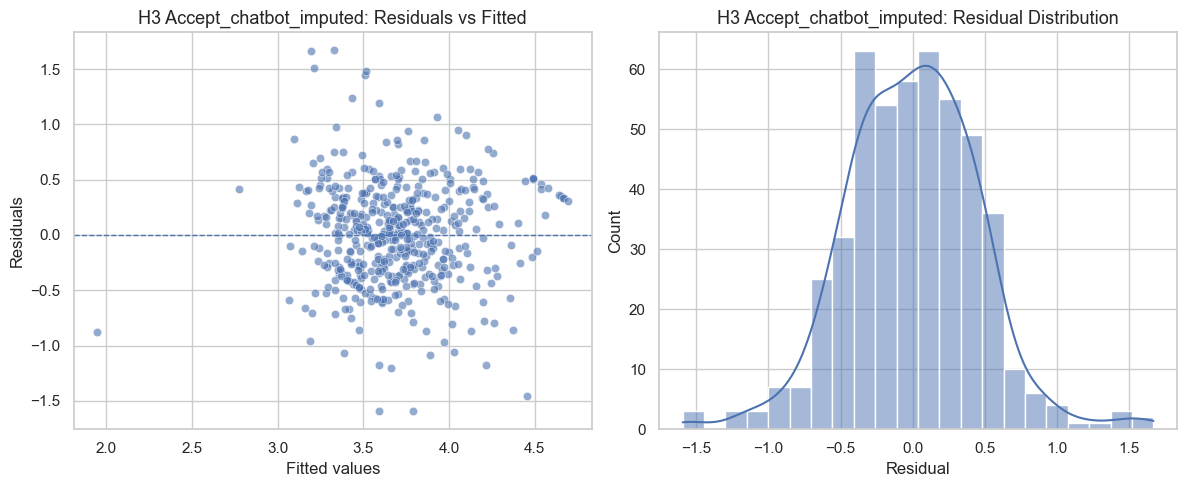

In [27]:
if focal_role_model is not None:
    focal_df = h3_models[focal_outcome]["data"].copy()
    focal_df["fitted_h3"] = focal_role_model.fittedvalues
    focal_df["resid_h3"] = focal_role_model.resid

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Residuals vs fitted
    sns.scatterplot(
        x="fitted_h3",
        y="resid_h3",
        data=focal_df,
        ax=axes[0],
        alpha=0.6
    )
    axes[0].axhline(0, linestyle="--", linewidth=1)
    axes[0].set_xlabel("Fitted values")
    axes[0].set_ylabel("Residuals")
    axes[0].set_title(f"H3 {focal_outcome}: Residuals vs Fitted")

    # Residual distribution
    sns.histplot(focal_df["resid_h3"], kde=True, ax=axes[1])
    axes[1].set_xlabel("Residual")
    axes[1].set_title(f"H3 {focal_outcome}: Residual Distribution")

    plt.tight_layout()
    plt.show()


# 6.0. Plot-Ready Predictions: SDT × Country × Role
- This builds a grid over SDT (TENS) and generates predicted acceptance for each combination of Country × role_label, so you can visualize how the SDT slope changes by context.

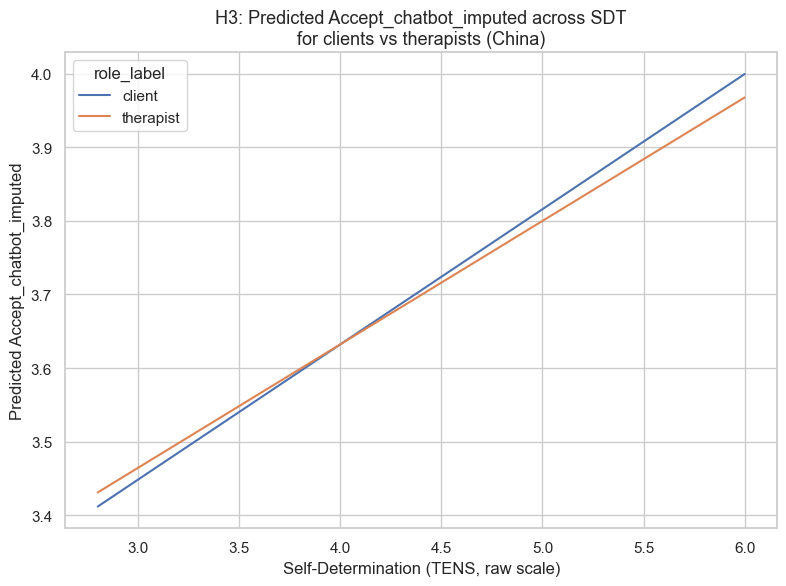

In [ ]:
if focal_role_model is not None:
    focal_df = h3_models[focal_outcome]["data"]

    tens_min = focal_df["TENS_Life_mean_imputed_c"].quantile(0.05)
    tens_max = focal_df["TENS_Life_mean_imputed_c"].quantile(0.95)
    tens_grid = np.linspace(tens_min, tens_max, 50)

    # Typical covariate profile
    gender_ref = focal_df["gender"].mode()[0]
    age_ref = 0.0  # centered
    phq_mean = focal_df["PHQ5_mean_imputed"].mean()
    ssrph_mean = focal_df["SSRPH_mean_imputed"].mean()
    gaa_mean = focal_df["GAAIS_mean_imputed"].mean()
    et_mean = focal_df["ET_mean_imputed"].mean()

    role_levels = ["client", "therapist"]

    pred_rows = []
    for role in role_levels:
        for t_val in tens_grid:
            pred_rows.append({
                "TENS_Life_mean_imputed_c": t_val,
                "age_imputed_c": age_ref,
                "gender": gender_ref,
                "role_label": role,
                "PHQ5_mean_imputed": phq_mean,
                "SSRPH_mean_imputed": ssrph_mean,
                "GAAIS_mean_imputed": gaa_mean,
                "ET_mean_imputed": et_mean,
            })

    pred_df = pd.DataFrame(pred_rows)
    pred_df["pred_accept"] = focal_role_model.predict(pred_df)

    # Use the China sample mean for raw reconstruction
    tens_raw_mean = context_df["TENS_Life_mean_imputed"].mean()
    pred_df["TENS_Life_raw"] = (
        pred_df["TENS_Life_mean_imputed_c"] + tens_raw_mean
    )

    plt.figure(figsize=(8, 6))
    sns.lineplot(
        data=pred_df,
        x="TENS_Life_raw",
        y="pred_accept",
        hue="role_label"
    )
    plt.xlabel("Self-Determination (TENS, raw scale)")
    plt.ylabel(f"Predicted {focal_outcome}")
    plt.title(
        f"H3: Predicted {focal_outcome} across SDT\n"
        "for clients vs therapists (China)"
    )
    plt.tight_layout()
    plt.show()